# 0. Install and Import Dependencies

In [1]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.6.0
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3


In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow

In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [6]:
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define the path to the directory containing your data
data_dir = '/content/drive/MyDrive/data/alignments/s1'

# Check the files in the data directory
print("Files in the data directory:")
for filename in os.listdir(data_dir):
    print(filename)


Mounted at /content/drive
Files in the data directory:
bwbt9a.align
prav9s.align
pgiq2n.align
bbwm6p.align
sgbv8n.align
pwbq7a.align
swwv9a.align
bgan7a.align
pbbv6n.align
pgak3s.align
brwa5a.align
srin5s.align
pgwlzn.align
prav8n.align
swai2p.align
bbal6n.align
bbil3s.align
lwwz9s.align
lbid2n.align
sbwb4p.align
pbbp3s.align
srbb4n.align
sbwh8p.align
bgan5s.align
prac6n.align
lbiq3a.align
swau9s.align
brbt2p.align
lwbszn.align
sgwq1a.align
srbo2n.align
swio2p.align
pbwx3a.align
bwba5s.align
pbap1a.align
bbaf4p.align
bgau1a.align
bgia5a.align
sgbv9s.align
swbp1a.align
pbbjzp.align
lbby5a.align
bbbf8p.align
lbay1a.align
bwwa9s.align
pgaezp.align
lgbm4p.align
brwa4p.align
pgak2n.align
sgwx4p.align
lrwf1s.align
swai1s.align
srah7a.align
bwba7a.align
bbbz9s.align
prwq2n.align
sbwu7a.align
sbbh5a.align
swbc3a.align
lrwz2n.align
lwwf7s.align
pgwy9s.align
srwi4p.align
lbbe1s.align
sbinzp.align
lrwl4n.align
braf9s.align
bwig2p.align
sbig6p.align
lbaq4n.align
bgbh5s.align
praxzp.align
lwar7s.al

In [7]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [8]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [9]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [10]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [11]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [12]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [13]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [14]:
def load_data(path: tf.Tensor):
    path = tf.convert_to_tensor(path).numpy().decode('utf-8')  # Convert to string
    file_name = os.path.splitext(os.path.basename(path))[0]
    video_path = os.path.join('/content/drive/MyDrive/data/s1', f'{file_name}.mpg')
    alignment_path = os.path.join('/content/drive/MyDrive/data/alignments/s1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments



In [15]:
test_path = './content/drive/MyDrive/data/s1/bbal6n.mpg'

In [16]:
frames, alignments = load_data(test_path)


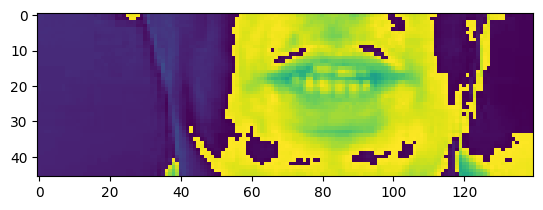

In [17]:
plt.imshow(frames[40])

In [18]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [19]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [20]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [21]:
from matplotlib import pyplot as plt

In [22]:
data = tf.data.Dataset.list_files('/content/drive/MyDrive/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [23]:
len(test)

50

In [24]:
frames, alignments = load_data(test_path)


In [25]:
len(frames)

75

In [26]:
sample = data.as_numpy_iterator()

In [27]:
val = sample.next(); val[0]

array([[[[[1.5166845 ],
          [1.5166845 ],
          [1.4787674 ],
          ...,
          [0.37917113],
          [0.37917113],
          [0.37917113]],

         [[1.4029332 ],
          [1.4787674 ],
          [1.4029332 ],
          ...,
          [0.37917113],
          [0.37917113],
          [0.37917113]],

         [[1.5546017 ],
          [1.5546017 ],
          [1.5546017 ],
          ...,
          [0.34125403],
          [0.30333692],
          [0.30333692]],

         ...,

         [[1.1375134 ],
          [1.0616791 ],
          [1.0616791 ],
          ...,
          [0.07583423],
          [0.07583423],
          [0.07583423]],

         [[1.0616791 ],
          [1.0616791 ],
          [1.0616791 ],
          ...,
          [0.03791711],
          [0.03791711],
          [0.03791711]],

         [[1.0616791 ],
          [1.0616791 ],
          [1.0616791 ],
          ...,
          [0.03791711],
          [0.03791711],
          [0.        ]]],


        [[[1.4408

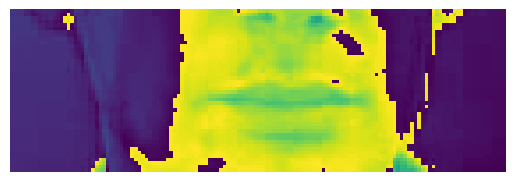

In [28]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Function to update each frame in the animation
def update(frame):
    plt.imshow(frame)
    plt.axis('off')

# Create a figure and axis
fig, ax = plt.subplots()

# Create the animation
anim = FuncAnimation(fig, update, frames=val[0][0], interval=100)

# Save the animation as a GIF
anim.save('./animation.gif', writer='pillow', fps=10)


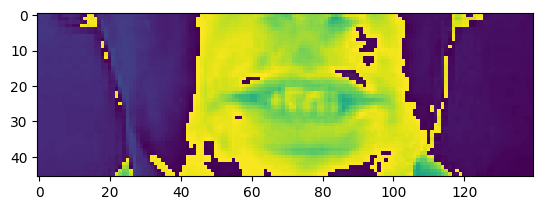

In [29]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [30]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'set green by c seven soon'>

# 3. Design the Deep Neural Network

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [32]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [33]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [35]:
5*17*75

6375

In [36]:
yhat = model.predict(val[0])

1/1 [==============================] - 12s 12s/step


In [37]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'uuooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooood'>

In [38]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'uuooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooood'>

In [39]:
model.input_shape

(None, 75, 46, 140, 1)

In [40]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [41]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [42]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [43]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [44]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
if len(data) == 0:
    raise ValueError("Error: Dataset is empty.")

# Split dataset into train and test
train_size = int(0.9 * len(data))
if train_size == 0:
    raise ValueError("Error: Dataset is too small for splitting.")
train_data = data.take(train_size)
test_data = data.skip(train_size)

# Verify dataset sizes
print("Train dataset size:", len(train_data))
print("Test dataset size:", len(test_data))

# Check if train_data and test_data contain any elements
if len(train_data) == 0 or len(test_data) == 0:
    raise ValueError("Error: Train or test dataset is empty.")
else:
    # Define callbacks
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('checkpoint', monitor='loss', save_weights_only=True)
    schedule_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    example_callback = ProduceExample(test_data)

    # Train the model
    model.fit(train_data, validation_data=test_data, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])



Train dataset size: 450
Test dataset size: 50
Epoch 1/100
 10/450 [..............................] - ETA: 6:37:01 - loss: 146.6412

# 5. Make a Prediction

In [2]:
import gdown
import zipfile

url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'

# Download the file
gdown.download(url, output, quiet=False)

# Extract the downloaded zip file
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('models')


Downloading...
From (original): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=709b1635-cb3e-4abb-83c6-55e51a745572
To: /content/checkpoints.zip
100%|██████████| 94.5M/94.5M [00:00<00:00, 124MB/s]


In [5]:
import tensorflow as tf

# Define the optimizer as a legacy optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model using the optimizer
model.compile(optimizer=optimizer, loss=CTCLoss)

# Initialize the model's variables
model.build((None, 75, 46, 140, 1))

# Create a Checkpoint object
checkpoint = tf.train.Checkpoint(model=model)

# Restore the weights
checkpoint.restore('models/checkpoint')

# Now the model weights are loaded


NameError: name 'model' is not defined

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
# Iterate over the dataset
for sample in test_data:
    # Extract the target labels or annotations from the sample
    target_labels = sample[1]
    # Process the target labels as needed
    print('~'*100, 'REAL TEXT')
    for sentence in target_labels:
        print(tf.strings.reduce_join([num_to_char(word) for word in sentence]))



In [ ]:
# Convert input_length tensor to int32 data type
input_length = tf.cast(input_length, tf.int32)

# Pass logits to the CTC decoder
decoded, log_prob = tf.nn.ctc_greedy_decoder(
    inputs=tf.transpose(logits, perm=[1, 0, 2]),  # Transpose if needed
    sequence_length=input_length,  # Ensure input_length is correctly specified and of int32 data type
    merge_repeated=merge_repeated  # Specify merge_repeated parameter
)

In [ ]:
print('~'*100, 'PREDICTIONS')
for sentence in decoded:
    prediction = tf.sparse.to_dense(sentence).numpy()
    decoded_prediction = tf.strings.reduce_join([num_to_char(word) for word in prediction]).numpy().decode('utf-8')
    print(decoded_prediction)



# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('./content/drive/MyDrive/data/s1/bbal7s.mpg'))

In [ ]:
import tensorflow as tf

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')


In [ ]:
print('~'*100, 'REAL TEXT')
real_text = [tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for sentence in [sample[1]]]
print(real_text)

yhat = model.predict(tf.expand_dims(sample[0], axis=0))
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

print('~'*100, 'PREDICTIONS')
decoded_predictions = [tf.strings.reduce_join([num_to_char(word) for word in sentence]).numpy().decode('utf-8') for sentence in decoded]
print(decoded_predictions)
